In [3]:
%matplotlib inline
import pandas as apd
import numpy as np
import matplotlib.pyplot as plt
from datasets import dataset_info, dataset_load

## Data Experiments
---
Now lets take a look at a particular real-life data problem. In the following example we take a look at the prediction of ozone concentration as a factor of other weather-based features. As with all data problems, it behooves us to take a look at all of the information that we have about the dataset.

In [4]:
dataset_info('laozone')

These data record the level of atmospheric ozone concentration from
eight daily meteorological measurements made in the Los Angeles basin
in 1976.  Although measurements were made every day that year, some
observations were missing; here we have the 330 complete cases.  The
data were given to us by Leo Breiman; he was a consultant on a project
from which these data are taken.  The response, referred to as ozone,
is actually the log of the daily maximum of the hourly-average ozone
concentrations in Upland, California.

To read into R:
LAozone = read.table("http://www-stat.stanford.edu/~tibs/ElemStatLearn/datasets/LAozone.data",sep=",",head=T)

Detailed variable names:

ozone : Upland Maximum Ozone
vh : Vandenberg 500 mb Height
wind : Wind Speed (mph)
humidity : Humidity (%)
temp : Sandburg AFB Temperature
ibh : Inversion Base Height
dpg : Daggot Pressure Gradient
ibt : Inversion Base Temperature
vis : Visibility (miles)
doy : Day of the Year


Now lets take a look at what this dataset looks like. 

In [5]:
data = dataset_load('laozone')
print(data)

     ozone    vh  wind  humidity  temp   ibh  dpg  ibt  vis  doy
0        3  5710     4        28    40  2693  -25   87  250    3
1        5  5700     3        37    45   590  -24  128  100    4
2        5  5760     3        51    54  1450   25  139   60    5
3        6  5720     4        69    35  1568   15  121   60    6
4        4  5790     6        19    45  2631  -33  123  100    7
5        4  5790     3        25    55   554  -28  182  250    8
6        6  5700     3        73    41  2083   23  114  120    9
7        7  5700     3        59    44  2654   -2   91  120   10
8        4  5770     8        27    54  5000  -19   92  120   11
9        6  5720     3        44    51   111    9  173  150   12
10       5  5760     6        33    51   492  -44  181   40   13
11       4  5780     6        19    54  5000  -44  135  200   14
12       4  5830     3        19    58  1249  -53  243  250   15
13       7  5870     2        19    61  5000  -67  186  200   16
14       5  5840     5   

Alright, we're ready to get started ! Now, before we touch anything, we need to follow best practices. When faced with a new dataset, we need to set up some kind of objective comparison. To do this, we need to split our dataset into three parts: **Training**(and within that, **Validation**), and **Testing** sets. 

The best practice here is to take the test data and lock it away somewhere. It is always tempting to tune your algorithms to give the best test performance. However, even if the regression isn't explicitly *trained* on the test data, as practitioners, we could be continually making changes in an effort to get our numbers up.

Instead, we should deep-freeze the test data, and then tune as much as we can via **cross-validation (CV)** on our training data.

In [6]:
# from sklearn import linear_model, svm, ensemble
from sklearn.model_selection import train_test_split, KFold

#--- Convert from DataFrame to NDArray ---#
# We also ensure that we load in all data as floating point values
# so that we don't miss anything to truncations.
y = data['ozone'].as_matrix().astype(float)
X = data[[i for i in range(1,10)]].as_matrix().astype(float)

#--- Split Dataset ---#
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size = 0.25, random_state=1)

print("Training Samples: ", len(yTrain))
print("Testing  Samples: ", len(yTest))

Training Samples:  247
Testing  Samples:  83


Now, before we start attempting to fit models, lets take a bit of care and apply some pre-processing to our dataset. The de-facto pre-processing is *centering and normalization*. Specifically, many flavors of estimators (OLS, RR, etc.) can be thrown of by large differences in of scale and variations between the features. We can easily account for this in our estimators by simply normalizing the feature columns and removing averages. Scikit-Learn has some features for this.

In [7]:
from sklearn import preprocessing

#--- Adding Features ... ---#
# Can you think of any other possible features to include, here?
# What other pre-processing steps might you use?


#--- Center and Scale ---#
XTest = preprocessing.scale(XTest)
XTrain = preprocessing.scale(XTrain)

#--- Center observations ---#
mean_yTrain = np.mean(yTrain)
mean_yTest = np.mean(yTest)

yTrain = yTrain - mean_yTrain
yTest = yTest - mean_yTest

Now it is time for us to choose our estimator. What should we choose? 

## Attempt 1: OLS
---


Normalized RSS (Train): 18.28
Normalized RSS  (Test): 22.57


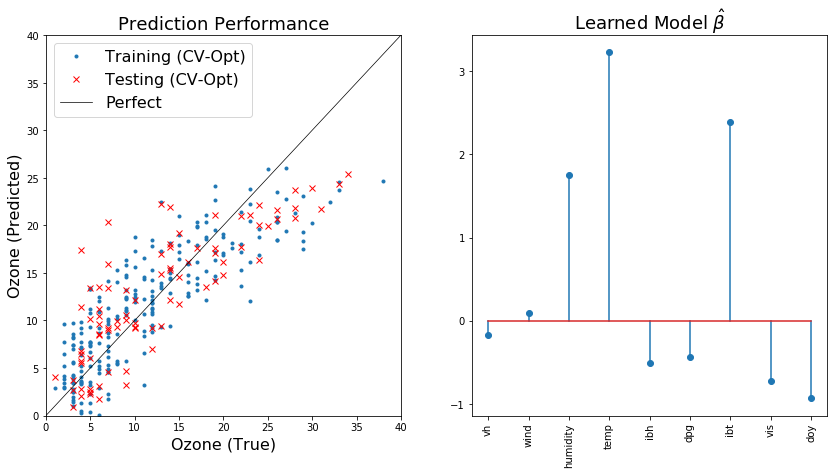

In [93]:
#--- Calculate the OLS Estimate ---#
regOLS = np.linalg.solve(np.dot(XTrain.T,XTrain), np.dot(XTrain.T,yTrain))

yp = np.dot(XTrain, regOLS)
ypTest = np.dot(XTest, regOLS)

#--- Visualize ---#
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(yTrain + mean_yTrain,yp + mean_yTrain,'.', label='Training (CV-Opt)')
plt.plot(yTest + mean_yTest, ypTest + mean_yTest,'.r', label='Testing (CV-Opt)', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)
# Plot the learned model
plt.subplot(122)
plt.stem(regRR.coef_)
plt.title('Learned Model $\\hat{\\beta}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical')

#--- Print RSS ---#
rss_train = np.mean(np.power(yTrain - yp,2))
rss_test = np.mean(np.power(yTest - ypTest,2))
print("Normalized RSS (Train): %0.2f" % rss_train)
print("Normalized RSS  (Test): %0.2f" % rss_test)

## Attempt 2: Ridge Regression
---

In [94]:
from sklearn import linear_model

#--- Define Regression Estimator ---#
regRR = linear_model.Ridge(alpha=0.01)

Now, we need to perform some kind of CV to find the best set of parameters for our model. We will do this by constructing a **Pipeline**. A pipeline is a useful way of handling pre-processing on separate data partitions when performing CV. Let's take a look at that.

In [97]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline 

#--- Make a Pre-processing + Fitting Pipeline ---#
pipe_regRR = make_pipeline(preprocessing.StandardScaler(), regRR)

#--- Define a Scoring Metric ---#
# To compare fits, we look at the prediction error via the RSS.
def neg_rss(reg, X, y):
    yp = reg.predict(X)
    return -np.mean(np.power(y - yp,2))

#--- Define CV Splitting ---#
# We can create an iterator which performs a set of randomized 
# splits on the dataset into "train" and "validation". We have
# a natural tradeoff between the test set size and the number of 
# splits we should perform
cv = ShuffleSplit(n_splits=20, test_size=0.05, random_state=0)

#--- Define the Parameters to Search ---#
# We need to specify the estimator name since we are performing a CV on
# a Pipeline. (e.g. the formatting of `<estimator>__<param>`).
param_grid = [
    {'ridge__alpha': np.logspace(-4,3,50)}
]

#--- Run the CV ---#
cv_regRR = GridSearchCV(pipe_regRR, param_grid, scoring=neg_rss, cv=cv)
cv_regRR.fit(XTrain,yTrain)

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=0, test_size=0.05, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'ridge__alpha': array([  1.00000e-04,   1.38950e-04,   1.93070e-04,   2.68270e-04,
         3.72759e-04,   5.17947e-04,   7.19686e-04,   1.00000e-03,
         1.38950e-03,   1.93070e-03,   2.68270e-03,   3.72759e-03,
         5.17947e-03,   7.19686e-03,   1.00000e-02,   1.38950e-02,
   ...   1.93070e+02,   2.68270e+02,   3.72759e+02,   5.17947e+02,
         7.19686e+02,   1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function neg_rss at 0x122aac598>, verbose=0)

Great ! Now lets take a look at the performance of our estimator. Here, for an example of Ridge or Lasso regression, we chart over the $\alpha$ parameter that we perform CV against.

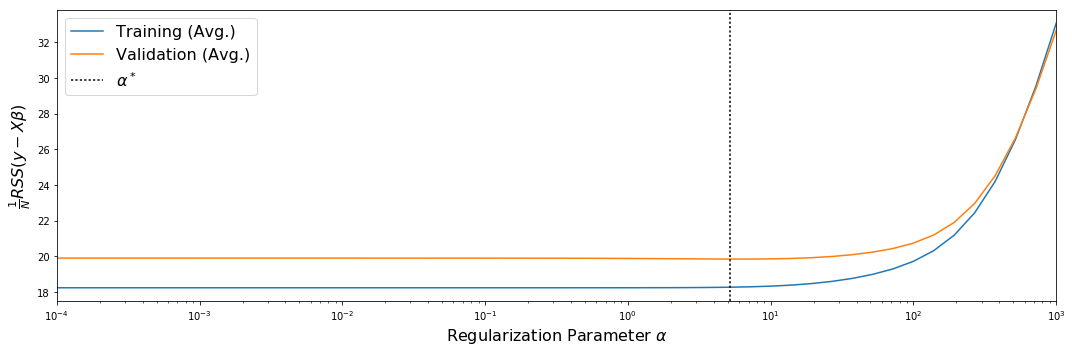

In [98]:
#--- Record CV Optimizing Hyper-Params ---#
cvOptAlpha = cv_regRR.cv_results_['param_ridge__alpha'][cv_regRR.best_index_]
cvOptParams = cv_regRR.cv_results_['params'][cv_regRR.best_index_]

#--- Visualize ---#
testedAlpha = cv_regRR.cv_results_['param_ridge__alpha']
trainScores = -cv_regRR.cv_results_['mean_train_score']   # Reverse Sign
testScores = -cv_regRR.cv_results_['mean_test_score']     # Reverse Sign

plt.figure(figsize=(15,5))
plt.plot(testedAlpha, trainScores, '-', label='Training (Avg.)')
plt.plot(testedAlpha, testScores, '-', label='Validation (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS(y - X\\beta)$', fontsize=16)
plt.axvline(cvOptAlpha, label='$\\alpha^*$', color='k', linestyle=':')
plt.xscale('log')
plt.xlim([1e-4, 1e3])
plt.tight_layout()
plt.legend(loc=2, fontsize=16)

Now, lets take a look at how well we are able to make our predictions on the training set using this CV optimal value of $\alpha$.

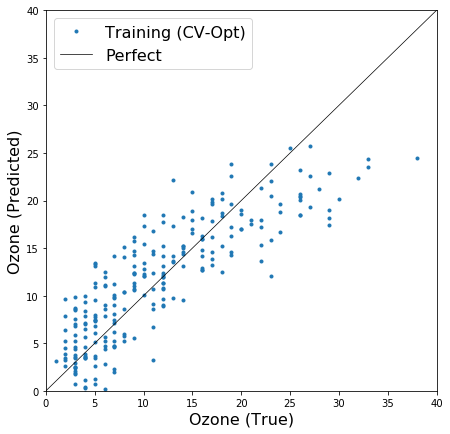

In [99]:
#--- Get Training Predicitions ---#
pipe_regRR.set_params(ridge__alpha=cvOptAlpha)
pipe_regRR.fit(XTrain,yTrain)
yp = pipe_regRR.predict(XTrain)

#--- Visualize ---#
plt.figure(figsize=(7,7))
plt.plot(yTrain + mean_yTrain,yp + mean_yTrain,'.', label='Training (CV-Opt)')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16);

And now, finally, we are ready to take our test data out of deep-freeze. How did we do?

Normalized RSS (Train): 18.30
Normalized RSS  (Test): 22.57


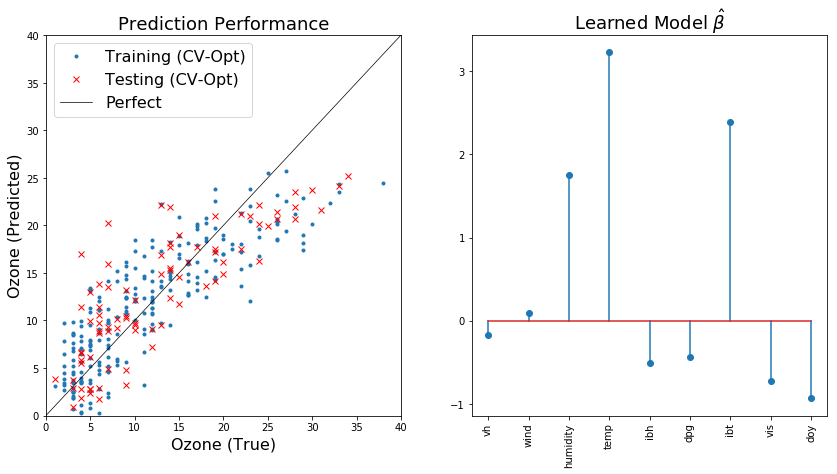

In [100]:
ypTest = pipe_regRR.predict(XTest)

#--- Visualize ---#
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(yTrain + mean_yTrain,yp + mean_yTrain,'.', label='Training (CV-Opt)')
plt.plot(yTest + mean_yTest, ypTest + mean_yTest,'.r', label='Testing (CV-Opt)', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)
# Plot the learned model
plt.subplot(122)
plt.stem(regRR.coef_)
plt.title('Learned Model $\\hat{\\beta}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical')

#--- Print RSS ---#
print("Normalized RSS (Train): %0.2f" % -neg_rss(pipe_regRR, XTrain, yTrain))
print("Normalized RSS  (Test): %0.2f" % -neg_rss(pipe_regRR, XTest, yTest))

## Attempt 3: Lasso
---


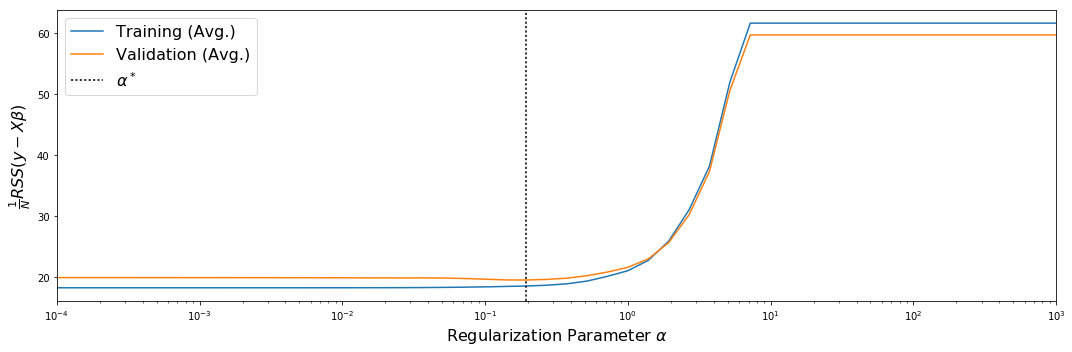

In [51]:
#--- Construct Estimator ---#
regLasso = linear_model.Lasso(alpha=1.0)

#--- Make a Pre-processing + Fitting Pipeline ---#
pipe_regLasso = make_pipeline(preprocessing.StandardScaler(), regLasso)

#--- Define a Scoring Metric ---#
# To compare fits, we look at the prediction error via the RSS.
def neg_rss(reg, X, y):
    yp = reg.predict(X)
    return -np.mean(np.power(y - yp,2))

#--- Define the Parameters to Search ---#
# We need to specify the estimator name since we are performing a CV on
# a Pipeline. (e.g. the formatting of `<estimator>__<param>`).
param_grid = [
    {'lasso__alpha': np.logspace(-4,3,50)}
]

#--- Run the CV ---#
cv_regLasso = GridSearchCV(pipe_regLasso, param_grid, scoring=neg_rss, cv=cv)
cv_regLasso.fit(XTrain,yTrain)

#--- Record CV Optimizing Hyper-Params ---#
cvOptAlphaLasso = cv_regLasso.cv_results_['param_lasso__alpha'][cv_regLasso.best_index_]
cvOptParamsLasso = cv_regLasso.cv_results_['params'][cv_regLasso.best_index_]

#--- Visualize ---#
testedAlpha = cv_regLasso.cv_results_['param_lasso__alpha']
trainScores = -cv_regLasso.cv_results_['mean_train_score']   # Reverse Sign
testScores = -cv_regLasso.cv_results_['mean_test_score']     # Reverse Sign

plt.figure(figsize=(15,5))
plt.plot(testedAlpha, trainScores, '-', label='Training (Avg.)')
plt.plot(testedAlpha, testScores, '-', label='Validation (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS(y - X\\beta)$', fontsize=16)
plt.axvline(cvOptAlphaLasso, label='$\\alpha^*$', color='k', linestyle=':')
plt.xscale('log')
plt.xlim([1e-4, 1e3])
plt.tight_layout()
plt.legend(loc=2, fontsize=16)

Normalized RSS (Train): 18.55
Normalized RSS  (Test): 22.06


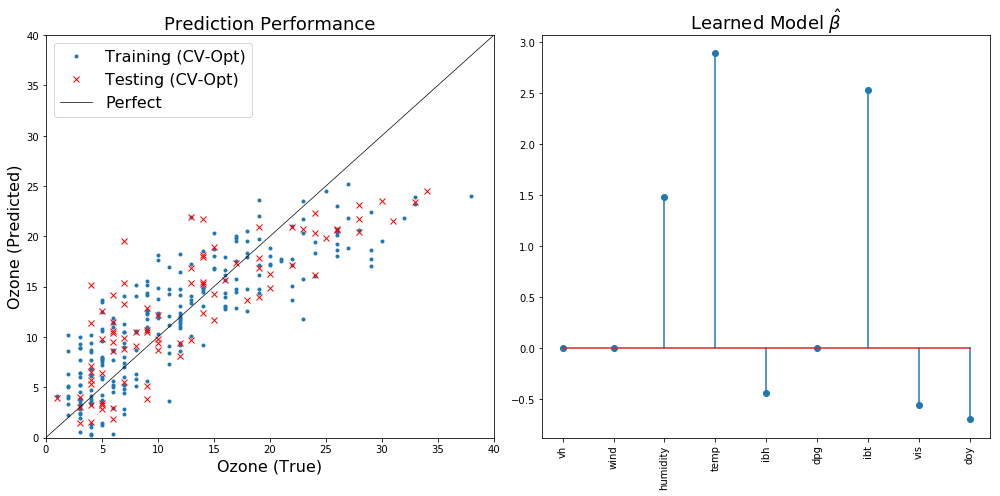

In [83]:
#--- Get Training Predicitions ---#
pipe_regLasso.set_params(lasso__alpha=cvOptAlphaLasso)
pipe_regLasso.fit(XTrain,yTrain)
yp = pipe_regLasso.predict(XTrain)
ypTest = pipe_regLasso.predict(XTest)

#--- Visualize ---#
# Plot prediction performance
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(yTrain + mean_yTrain,yp + mean_yTrain,'.', label='Training (CV-Opt)')
plt.plot(yTest + mean_yTest, ypTest + mean_yTest,'.r', label='Testing (CV-Opt)', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)
# Plot the learned model
plt.subplot(122)
plt.stem(regLasso.coef_)
plt.title('Learned Model $\\hat{\\beta}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical')

plt.tight_layout()
#--- Print RSS ---#
print("Normalized RSS (Train): %0.2f" % -neg_rss(pipe_regLasso, XTrain, yTrain))
print("Normalized RSS  (Test): %0.2f" % -neg_rss(pipe_regLasso, XTest, yTest))

## Boosting
---
With boosing methods, over-training becomes a very real possibility. In this case we need to make sure to use our CV in order to stop fine-tuning our boosting approach when we start to have a loss on the validation data.

We also have many possible different metrics to use in this case, not just the RSS. So, it is important to use our CV parameter grid to check many possible values.

In [123]:
from sklearn import ensemble

#--- Create Estimator Object ---#
regGB = ensemble.GradientBoostingRegressor()

#--- Make a Pre-processing + Fitting Pipeline ---#
pipe_regGB = make_pipeline(preprocessing.StandardScaler(), regGB)

#--- Define the Parameters to Search ---#
# We need to specify the estimator name since we are performing a CV on
# a Pipeline. (e.g. the formatting of `<estimator>__<param>`).
param_grid = [
    {'gradientboostingregressor__loss': ['ls','lad'], 
     'gradientboostingregressor__learning_rate': np.logspace(-3,0,20),
     'gradientboostingregressor__n_estimators': range(50,500,50)} 
]

#--- Run the CV ---#
cv_regGB = GridSearchCV(pipe_regGB, param_grid, scoring=neg_rss, cv=cv)
cv_regGB.fit(XTrain,yTrain)

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=0, test_size=0.05, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, mi...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'gradientboostingregressor__loss': ['ls', 'lad'], 'gradientboostingregressor__learning_rate': array([ 0.001  ,  0.00144,  0.00207,  0.00298,  0.00428,  0.00616,
        0.00886,  0.01274,  0.01833,  0.02637,  0.03793,  0.05456,
        0.07848,  0.11288,  0.16238,  0.23357,  0.33598,  0.48329,
        0.69519,  1.     ]), 'gradientboostingregressor__n_estimators': range(50, 500, 50)}

In [124]:
cv_regGB.cv_results_['params'][cv_regGB.best_index_]
cv_regGB.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.078475997035146114, loss='lad', max_depth=3,
             max_features=None, max_l...s=400, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

In [122]:
#--- Get Training Predicitions ---#
pipe_regGB.set_params(cv_re)
pipe_regGB.fit(XTrain,yTrain)
yp = pipe_regLasso.predict(XTrain)
ypTest = pipe_regLasso.predict(XTest)

#--- Visualize ---#
# Plot prediction performance
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(yTrain + mean_yTrain,yp + mean_yTrain,'.', label='Training (CV-Opt)')
plt.plot(yTest + mean_yTest, ypTest + mean_yTest,'.r', label='Testing (CV-Opt)', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)
# Plot the learned model
plt.subplot(122)
plt.stem(regLasso.coef_)
plt.title('Learned Model $\\hat{\\beta}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical')

plt.tight_layout()
#--- Print RSS ---#
print("Normalized RSS (Train): %0.2f" % -neg_rss(pipe_regLasso, XTrain, yTrain))
print("Normalized RSS  (Test): %0.2f" % -neg_rss(pipe_regLasso, XTest, yTest))